# Applicazione del transfer learning con Inception-v3

Inecption_v3 è un metodo di classificazione di immagini sviluppato da google sulle le immagini di ImageNET.

[ImageNET](http://image-net.org/index) è un dataset di immagini di vario tipo utilizzato per il training di molti modelli di Reti Neurali. 

## Dati 17 Flowers (Oxford)
http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html

## Legge le immagini dalla directory e le carica su una matrice 4D
We have created a 17 category flower dataset with 80 images for each class. The flowers chosen are some common flowers in the UK. The images have large scale, pose and light variations and there are also classes with large varations of images within the class and close similarity to other classes.

## ATTENZIONE
## Applicazione ridotta a 4 classi per permettere l'elaborazione in classe!
## Per poter eseguire la classificazione è necessario importare il file zip


In [0]:
import zipfile
!unzip jpg4.zip

Archive:  jpg4.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of jpg4.zip or
        jpg4.zip.zip, and cannot find jpg4.zip.ZIP, period.


In [0]:
%tensorflow_version 2.x
import numpy as np
from tensorflow.keras.utils import to_categorical

La lettura dei dati avviene tramite una funzione di Keras che legge la directory e le immagini nelle sottodirectory, assegnando come label la sequenza della sottodirectory. Inoltre questa funzione permette di resize le immagini, shuffle, scale, generare nuove immagini leggermente modificate. In particolare:
- ImageDataGenerator 
permette di scalare i valori, generare nuove immagini leggermente modificate. Crea l'oggetto ImageDataGenerator
- flow_from_directory (metodo di ImageDataGenerator)
permette di resize, shuffle, trasformare la target in 17 dummies. Ritorna un oggetto DirectoryIterator

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

clas = ['0','2','4','9']
MM = ImageDataGenerator()
#MM = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2)
data = MM.flow_from_directory('JPG', target_size=(299, 299), color_mode='rgb', \
                                 classes=clas, class_mode='categorical', batch_size=500, shuffle=True)
Xval = data[0][0][:80]
Yval = data[0][1][:80]
Xtrain = data[0][0][80:]
Ytrain = data[0][1][80:]
del data
print("Immagini di training e validation caricate")

Found 320 images belonging to 4 classes.
Immagini di training e validation caricate


In [0]:
import numpy
unique_elements, counts_elements = np.unique(Ytrain[:,0], return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))
print(Ytrain[0:10])

Frequency of unique values of the said array:
[[  0.   1.]
 [179.  61.]]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [0]:
print("Dimensioni delle matrici:")
print(Xtrain.shape,Ytrain.shape,Xval.shape,Yval.shape)
vocab = ['Daffodils','LilyValley','Crocus','Sunflower']

Dimensioni delle matrici:
(240, 299, 299, 3) (240, 4) (80, 299, 299, 3) (80, 4)



## Vediamo qualche immagine ...

Fiore selezionato: LilyValley


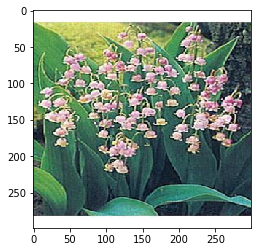

Fiore selezionato: Sunflower


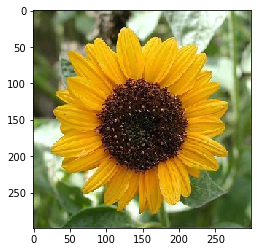

In [0]:
from tensorflow.python.keras.preprocessing import image
from skimage import transform
import matplotlib.pyplot as plt
%matplotlib inline
# per plottare a video utilizzo matplotlib. Se A è float richiede valori nell'intervallo [0,1]
h = 50
print("Fiore selezionato:",vocab[np.argmax(Ytrain[h])])
plt.imshow((Xtrain[h,:,:,:]/255.),alpha=1)
plt.show()
print("Fiore selezionato:",vocab[np.argmax(Yval[h])])
plt.imshow((Xval[h,:,:,:]/255.),alpha=1)
plt.show()

## Costruiamo il modello partendo da quello già stimato inception-v3

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD


## Per richiamare il modello stimato (>90MB)
keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', 
                                            input_tensor=None, input_shape=None, pooling=None, classes=1000)

The default input size for this model is 299x299.
### Arguments
**include_top: whether to include the fully-connected layer at the top of the network.**

**weights: one of None (random initialization) or 'imagenet' (pre-training on ImageNet).**

input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.

input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be  (299, 299, 3) (with 'channels_last' data format) or (3, 299, 299) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 139. E.g. (150, 150, 3) would be one valid value.

pooling: Optional pooling mode for feature extraction when include_top is False.
None means that the output of the model will be the 4D tensor output of the last convolutional layer.
'avg' means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor.
'max' means that global max pooling will be applied.

classes: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.


## Carica il modello inception-v3 senza l'ultimo strato (fully connected) e lo strato di output (softmax)


In [0]:
# create the base pre-trained model: non include ultimo strato di classificazione (Top Layer)
base_model = InceptionV3(weights='imagenet', include_top=False)

In [0]:
print(base_model.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

## Definisce il nuovo modello
1.
aggiunge uno strato di riduzione media "GlobalAveragePooling", che schiaccia l'output ad un vettore di 2048 valori, necessario per far seguire uno strato Dense.

2.
Aggiunge quindi uno strato "Dense" fully connected con 1024 neuroni e lo strato di output SOFTMAX con 4 classi.

In [0]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3,seed=11)(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 4 classes
predictions = Dense(4, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
# let's visualize layer names and layer indices 
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_2
1 conv2d_94
2 batch_normalization_94
3 activation_94
4 conv2d_95
5 batch_normalization_95
6 activation_95
7 conv2d_96
8 batch_normalization_96
9 activation_96
10 max_pooling2d_4
11 conv2d_97
12 batch_normalization_97
13 activation_97
14 conv2d_98
15 batch_normalization_98
16 activation_98
17 max_pooling2d_5
18 conv2d_102
19 batch_normalization_102
20 activation_102
21 conv2d_100
22 conv2d_103
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_99
29 conv2d_101
30 conv2d_104
31 conv2d_105
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed0
41 conv2d_109
42 batch_normalization_109
43 activation_109
44 conv2d_107
45 conv2d_110
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 average_pooling2d_10
51 conv2d_106
52 conv2d_108
53 conv2d

## congela tutti gli strati eccetto il top

In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

## Effettua la stima dei parametri solo dei top layers

In [0]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.3,horizontal_flip=True)
# train the model on the new data for a few epochs
model.fit_generator(datagen.flow(Xtrain,Ytrain,batch_size=64), epochs=10, steps_per_epoch=(len(Ytrain)/32), \
                  validation_data=((Xval/255.),Yval) )

Epoch 1/10
8/7 [================================] - 18s 2s/step - loss: 7.5433 - acc: 0.2792 - val_loss: 4.4982 - val_acc: 0.3375
Epoch 2/10
8/7 [================================] - 17s 2s/step - loss: 1.2340 - acc: 0.6354 - val_loss: 1.0530 - val_acc: 0.5625
Epoch 3/10
8/7 [================================] - 17s 2s/step - loss: 0.5643 - acc: 0.7375 - val_loss: 0.3295 - val_acc: 0.9125
Epoch 4/10
8/7 [================================] - 17s 2s/step - loss: 0.5940 - acc: 0.7958 - val_loss: 0.5730 - val_acc: 0.7625
Epoch 5/10
8/7 [================================] - 17s 2s/step - loss: 0.3060 - acc: 0.8938 - val_loss: 0.2584 - val_acc: 0.9125
Epoch 6/10
8/7 [================================] - 17s 2s/step - loss: 0.3696 - acc: 0.8438 - val_loss: 0.5299 - val_acc: 0.8000
Epoch 7/10
8/7 [================================] - 17s 2s/step - loss: 0.1202 - acc: 0.9583 - val_loss: 0.4755 - val_acc: 0.8625
Epoch 8/10
8/7 [================================] - 17s 2s/step - loss: 0.6624 - acc: 0.80

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
yyy = model.predict(Xval/255)
score = model.evaluate(Xval/255, Yval)
print(model.metrics_names,score)
yvero = np.argmax(Yval,axis=1)
ystim = np.argmax(yyy,axis=1)
print(confusion_matrix(yvero,ystim))

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## fine tuning includendo anche 2 inception blocks

Questo step è molto lungo. Si tratta di 150 strati.

Possiamo usare il modello precedentemente salvato.

In [0]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['acc'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit_generator(datagen.flow(Xtrain,Ytrain,batch_size=32), epochs=150, \
                    steps_per_epoch=(len(Ytrain)/32), validation_data=((Xval/255),Yval),initial_epoch=0)


Epoch 1/150
8/7 [================================] - 14s 2s/step - loss: 1.2501 - acc: 0.7000 - val_loss: 0.4586 - val_acc: 0.8125
Epoch 2/150
8/7 [================================] - 10s 1s/step - loss: 0.8108 - acc: 0.7500 - val_loss: 0.2554 - val_acc: 0.9250
Epoch 3/150
8/7 [================================] - 10s 1s/step - loss: 0.5172 - acc: 0.8500 - val_loss: 0.1856 - val_acc: 0.9625
Epoch 4/150
8/7 [================================] - 10s 1s/step - loss: 0.3967 - acc: 0.8750 - val_loss: 0.1584 - val_acc: 0.9625
Epoch 5/150
8/7 [================================] - 10s 1s/step - loss: 0.2744 - acc: 0.9250 - val_loss: 0.1443 - val_acc: 0.9625
Epoch 6/150
8/7 [================================] - 10s 1s/step - loss: 0.2030 - acc: 0.9292 - val_loss: 0.1397 - val_acc: 0.9625
Epoch 7/150
8/7 [================================] - 10s 1s/step - loss: 0.1857 - acc: 0.9417 - val_loss: 0.1365 - val_acc: 0.9625
Epoch 8/150
8/7 [================================] - 10s 1s/step - loss: 0.1717 - a

In [0]:
yyy = model.predict(Xval/255)
score = model.evaluate(Xval/255, Yval)
print(model.metrics_names,score)
yvero = np.argmax(Yval,axis=1)
ystim = np.argmax(yyy,axis=1)
print(confusion_matrix(yvero,ystim))
print(classification_report(yvero,ystim))
#print(history['acc'],history['val_acc'])
#print(history.history)

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
# save the fitted model
# model.save("inception.h5")
# load the fitted model
from tensorflow.python.keras.models import load_model
model = load_model("inception.h5")

Your algorithm predicts [[0.0002 0.0001 0.0003 0.9994]]
Fiore selezionato: Sunflower


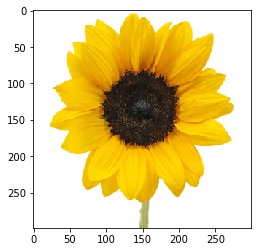

In [0]:
from tensorflow.python.keras.preprocessing import image
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
vocab = ['Daffodils','LilyValley','Crocus','Sunflower']
img_path = "sunflower.jpg"   # change this to the name of your image file 
# We preprocess the image to fit your algorithm.
img = image.load_img(img_path, target_size=(299, 299))
A = image.img_to_array(img)/255.
B = A.reshape(1,299,299,3)
my_prediction = model.predict(B)
np.set_printoptions(suppress=True,precision=4)
print("Your algorithm predicts",  my_prediction)
print("Fiore selezionato:",vocab[np.argmax(my_prediction)])
# per plottare a video utilizzo matplotlib. Se A è float richiede valori nell'intervallo [0,1]
plt.imshow(A)
plt.show()



# Utilizziamo il modello stimato sul WEB

Then open your browser.
Fill in the new picture you want to classify and submit, you will get prediction 